## Model
```python
Model(design):
    knot0 ~ Normal( μ0, σ0 )
    knot1 ~ Normal( μ1, σ1 )
    observation ~ Normal(knot0・(1-design) + knot1・design, 1)
```

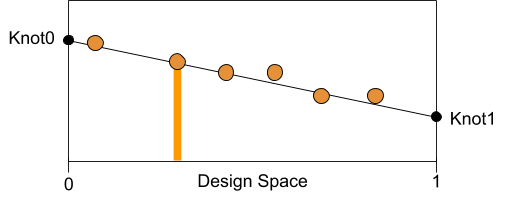

## Problem statment:
Choose design points D = [d1, d2, … dn], to optimally infer the Knot0 and Knot1. If a design point is on the left, more is learned about knot0 and less about knot1. Similarly, if a design point is on the right, then more is learned about knot1 and less about knot0.



In [1]:
import math
import pandas as pd
import matplotlib
import seaborn
import torch
import pyro
from pyro import poutine
from pyro.contrib.util import lexpand, rmv
from pyro.contrib.oed.eig import nmc_eig, vnmc_eig
from pyro.contrib.oed.differentiable_eig import (
        _differentiable_ace_eig_loss)
pyro.enable_validation(True)

In [19]:
def model(design):
    """
        :param torch.tensor design
             shape: [<batch_dims>, <design_size>]
    """
    
    batch_dims = design.shape[:-1]
    design_size = design.shape[-1]
    
    # Indicate that the batch dimensions are independent with a plate_stack over the <batch_dims>
    with pyro.plate_stack('plate_stack', batch_dims):

        # Define the prior distribution for the knots, p(theta).
        knot0_distribution = pyro.distributions.Normal(torch.tensor(0.0), torch.tensor(5.0))
        knot1_distribution = pyro.distributions.Normal(torch.tensor(0.0), torch.tensor(5.0))

        # Sample a common value of the knots for each batch.
        # The unsqueeze(-1) add dimension on the right that gets
        # broadcast across the <design_size> dimension
        #    knot0.shape = knot1.shape = [<batch_dims>, 1]
        knot0 = pyro.sample("knot0", knot0_distribution).unsqueeze(-1)
        knot1 = pyro.sample("knot1", knot1_distribution).unsqueeze(-1)
        
        # Define the observation distribution for an experiment
        # The .to_event(1) indicates design points are dependent
        observation_distribution = pyro.distributions.Normal(
            knot0*(1-design) + knot1*design, .1).to_event(1)
        
        # Sample observations at each design point in each batch
        #   observation.shape = [<batch_dims>, <design_size>]
        return pyro.sample("observation", observation_distribution) 

Plot `5000` experiments with `1000` design points each. 

design.shape: torch.Size([5000, 1000])
observations.shape: torch.Size([5000, 1000])


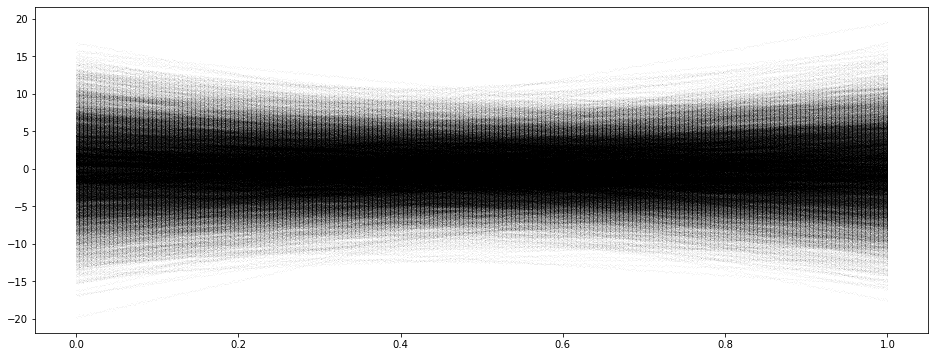

In [20]:
pyro.clear_param_store()
design = torch.linspace(start=0, end=1, steps=1000)
design = lexpand(design, 5000)
observations = model(design)

print(f"design.shape: {design.shape}")
print(f"observations.shape: {observations.shape}")

matplotlib.pyplot.figure(figsize=(16, 6))
seaborn.scatterplot(
    x=design.flatten(),
    y=observations.flatten(),
    alpha=.05,
    s=.1,
    color=matplotlib.colors.hex2color('#000000'),
    edgecolor=None)

## Solution: Nested Monte Carlo

Use Nested Monte Carlo to estimate an upperboud for the expected inforamtiong gain for designs that put different fractions of the desing points at either end of the range. For example, design_id is the sum across design points, so `design_id` == 17 corresponds to [0, 0, 0, 1, 1, ..., 1] 


In [28]:
pyro.clear_param_store()
design_size = 20
N = 10000
M = 100
M_prime = None
n_replicas = 20

designs = []
for i in range(design_size+1):
    design = (i)*[0.0] + (design_size-i)*[1.0]
    designs.append(design)

data=[]
for design in designs:
    for replica in range(n_replicas):
        eig = nmc_eig(
            model=model,
            design=torch.tensor(design),
            observation_labels=['observation'],
            target_labels=['knot0', 'knot1'],
            N = N,
            M = M,
            M_prime=M_prime)
        data.append({
            'design' : design,
            'design_id' : sum(design),
            'N' : N,
            'M' : M,
            'M_prime' : M_prime,
            'replica' : replica,
            'eig' : eig,
            'eig_mean' : eig.mean()
        })
        print(f"design: {design}")
        print(f"  eig: {eig}")
        print(f"  mean: {eig.mean()}")

design: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 73.89845275878906
  mean: 73.89845275878906
design: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 195.888427734375
  mean: 195.888427734375
design: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 421.0699462890625
  mean: 421.0699462890625
design: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 87.5534896850586
  mean: 87.5534896850586
design: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 97.55598449707031
  mean: 97.55598449707031
design: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 86.88288879394531
  mean: 86.88288879394531
design: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

design: [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 613.2924194335938
  mean: 613.2924194335938
design: [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 697.9711303710938
  mean: 697.9711303710938
design: [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 610.5869140625
  mean: 610.5869140625
design: [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 702.2504272460938
  mean: 702.2504272460938
design: [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 677.7662353515625
  mean: 677.7662353515625
design: [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 779.2413940429688
  mean: 779.2413940429688
design: [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.

design: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 945.0327758789062
  mean: 945.0327758789062
design: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1020.861572265625
  mean: 1020.861572265625
design: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 982.72119140625
  mean: 982.72119140625
design: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1124.728759765625
  mean: 1124.728759765625
design: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1236.3564453125
  mean: 1236.3564453125
design: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 946.8278198242188
  mean: 946.8278198242188
design: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0,

design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1187.1727294921875
  mean: 1187.1727294921875
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1188.5257568359375
  mean: 1188.5257568359375
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1095.998291015625
  mean: 1095.998291015625
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1150.0067138671875
  mean: 1150.0067138671875
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1021.1322021484375
  mean: 1021.1322021484375
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1164.945556640625
  mean: 1164.945556640625
design: [0.0, 0.0, 0.0, 0.0, 0.0

design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1185.4583740234375
  mean: 1185.4583740234375
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1159.51611328125
  mean: 1159.51611328125
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1071.617919921875
  mean: 1071.617919921875
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1172.5135498046875
  mean: 1172.5135498046875
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1204.872802734375
  mean: 1204.872802734375
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1040.5235595703125
  mean: 1040.5235595703125
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.

design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1093.5694580078125
  mean: 1093.5694580078125
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 954.0526733398438
  mean: 954.0526733398438
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1314.0296630859375
  mean: 1314.0296630859375
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 889.435791015625
  mean: 889.435791015625
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 960.318115234375
  mean: 960.318115234375
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1161.0037841796875
  mean: 1161.0037841796875
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
  eig: 1005.1984252929688
  mean: 1005.1984252929688
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
  eig: 958.0936279296875
  mean: 958.0936279296875
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
  eig: 785.1449584960938
  mean: 785.1449584960938
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
  eig: 819.9337768554688
  mean: 819.9337768554688
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
  eig: 798.88623046875
  mean: 798.88623046875
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
  eig: 872.88818359375
  mean: 872.88818359375
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
  eig: 572.0389404296875
  mean: 572.0389404296875
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
  eig: 653.5596923828125
  mean: 653.5596923828125
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
  eig: 664.6138916015625
  mean: 664.6138916015625
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
  eig: 773.5221557617188
  mean: 773.5221557617188
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
  eig: 668.2559204101562
  mean: 668.2559204101562
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
  eig: 664.965087890625
  mean: 664.965087890625
design: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

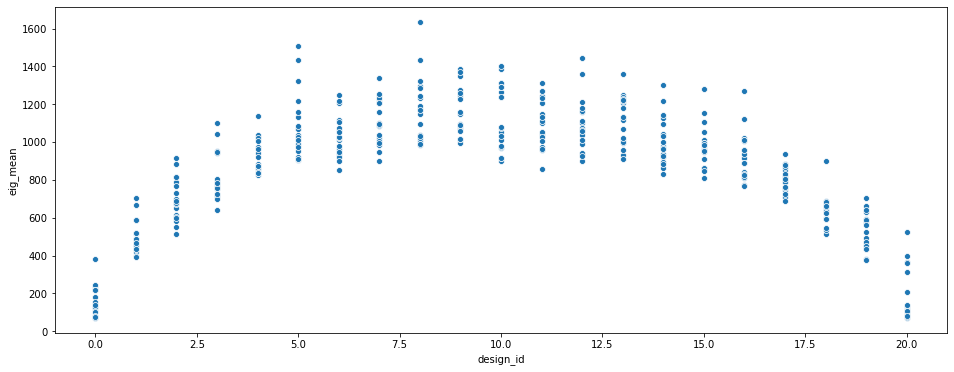

In [27]:
data = pd.DataFrame(data)
matplotlib.pyplot.figure(figsize=(16, 6))
seaborn.scatterplot(
    x='design_id',
    y='eig_mean',
    data=data)

## Solution ACE

Remake model where the design is trainable and the input `design_prototype` is just used to specify the shape.

To fit the model requires using a `guide`, a trainable variational network that maps the `observations` to the model parameters. The TensorLinear module is similar to `torch.nn.Linear` except the batching dimensions are handled differently.



In [5]:
def model_trainable(design_prototype):
    """
        :param torch.tensor design
             shape: [<batch_dims>, <design_size>]
    """
    
    batch_dims = design_prototype.shape[:-1]
    design_size = design_prototype.shape[-1]
    
    design = pyro.param(
        "design",
        torch.linspace(start=0, end=1, steps=design_size),
        constraint=torch.distributions.constraints.interval(0, 1)
    ).expand(design_prototype.shape)
    
    # Indicate that the batch dimensions are independent with a plate_stack over the <batch_dims>
    with pyro.plate_stack('plate_stack', batch_dims):

        # Define the prior distribution for the knots, p(theta).
        knot0_distribution = pyro.distributions.Normal(torch.tensor(0.0), torch.tensor(5.0))
        knot1_distribution = pyro.distributions.Normal(torch.tensor(0.0), torch.tensor(5.0))

        # Sample a common value of the knots for each batch.
        # The unsqueeze(-1) add dimension on the right that gets
        # broadcast across the <design_size> dimension
        #    knot0.shape = knot1.shape = [<batch_dims>, 1]
        knot0 = pyro.sample("knot0", knot0_distribution).unsqueeze(-1)
        knot1 = pyro.sample("knot1", knot1_distribution).unsqueeze(-1)
        
        # Define the observation distribution for an experiment
        # The .to_event(1) indicates design points are dependent
        observation_distribution = pyro.distributions.Normal(
            knot0*(1-design) + knot1*design, .1).to_event(1)
        
        # Sample observations at each design point in each batch
        #   observation.shape = [<batch_dims>, <design_size>]
        return pyro.sample("observation", observation_distribution) 

In [6]:
class TensorLinear(torch.nn.Module):

    __constants__ = ['bias']

    def __init__(self, *shape, bias=True):
        super(TensorLinear, self).__init__()
        self.in_features = shape[-2]
        self.out_features = shape[-1]
        self.batch_dims = shape[:-2]
        self.weight = torch.nn.Parameter(torch.Tensor(*self.batch_dims, self.out_features, self.in_features))
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(*self.batch_dims, self.out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        return pyro.contrib.util.rmv(self.weight, input) + self.bias

class PosteriorGuide(torch.nn.Module):
    def __init__(self, observation_dim, batching):
        super(PosteriorGuide, self).__init__()
        n_hidden = 64
        self.linear1 = TensorLinear(*batching, observation_dim, n_hidden)
        self.linear2 = TensorLinear(*batching, n_hidden, n_hidden)
        self.output_layer = TensorLinear(*batching, n_hidden, 2 + 2)
        self.softplus = torch.nn.Softplus()
        self.relu = torch.nn.ReLU()

    def forward(self, observation_dict, design_prototype, observation_labels, target_labels):
        y = observation_dict["observation"] - .5
        x = self.relu(self.linear1(y))
        x = self.relu(self.linear2(x))
        final = self.output_layer(x)

        knot0_mu = final[..., 0]
        knot0_sigma = self.softplus(final[..., 1])
        knot1_mu = final[..., 2]
        knot1_sigma = self.softplus(final[..., 3])

        pyro.module("posterior_guide", self)

        batch_shape = design_prototype.shape[:-1]
        with ExitStack() as stack:
            for plate in pyro.contrib.util.iter_plates_to_shape(batch_shape):
                stack.enter_context(plate)
            pyro.sample("knot0", pyro.distributions.Normal(knot0_mu, knot0_sigma))
            pyro.sample("knot1", pyro.distributions.Normal(knot1_mu, knot1_sigma))

In [9]:
from contextlib import ExitStack
import tqdm

pyro.clear_param_store()

design_size = 20    # number of design points
num_parallel = 10   # how many are in a batch
num_samples = 100   # number of contrastice samples for estimating bounds
num_steps = 10000   # optimization iterations
h_freq = 100

design_prototype = torch.zeros([num_parallel, design_size])
guide = PosteriorGuide(design_size, (num_parallel,))

eig_loss = _differentiable_ace_eig_loss(
    model_trainable,
    guide,
    num_samples,
    ['observation'],
    ['knot0', 'knot1'])
loss_fn = lambda *args, **kwargs: (-a for a in eig_loss(*args, **kwargs))

optim = pyro.optim.ExponentialLR({
    'optimizer': torch.optim.Adam,
    'optim_args': {'lr': .01},
    'gamma': 1.0})

params=None
baseline = 0.
for step in range(num_steps):
    if params is not None: pyro.infer.util.zero_grads(params)
    with pyro.poutine.trace(param_only=True) as param_capture:
        agg_loss, loss = loss_fn(
            design_prototype,
            num_samples,
            evaluation=True,
            control_variate=baseline)
    baseline = -loss.detach()
    params = set(site["value"].unconstrained() for site in param_capture.trace.nodes.values())
    agg_loss.backward(retain_graph=True)
    optim(params)
    optim.step()

    if step % h_freq == 0:
        a_design = pyro.param('design').squeeze().detach().clone().cpu().data.numpy()
        a_design.sort()
        print(a_design)
        print('eig', baseline.squeeze().mean())



> <ipython-input-9-c3e404acdff5>(43)<module>()
-> optim.step()
(Pdb) optim
(Pdb) dir(optim)
['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_optim', '_get_optim_args', '_state_waiting_to_be_consumed', 'get_state', 'kwargs', 'load', 'optim_objs', 'pt_optim_args', 'pt_optim_constructor', 'pt_scheduler_constructor', 'save', 'set_state', 'state_dict', 'step']
(Pdb) optim.optim_objs
{tensor([-87.3365,  -2.8804,  -2.1501,  -1.6640,  -1.3118,  -1.0196,  -0.7632,
         -0.5290,  -0.3085,  -0.0954,   0.0954,   0.3285,   0.5290,   0.7832,
          1.0196,   1.3118,   1.6840,   2.1501,   2.8804,  15.9357],
       requires_grad=True): <torch.optim.lr_scheduler.ExponentialLR object at 0

(Pdb) q


BdbQuit: 

In [2]:
import os
%load_ext tensorboard
root_dir = os.path.dirname(os.path.realpath("~/opt/MPLearn/vignettes/dose_response"))

In [3]:
from tensorboard import notebook
notebook.list()
%tensorboard --logdir {root_dir}

No known TensorBoard instances running.


In [ ]:
def run_toy_model():
    SEED = 2334
    torch.manual_seed(SEED)
    #np.random.seed(SEED)
    pyro.clear_param_store()


    logger = pytorch_lightning.loggers.TestTubeLogger(
        save_dir=root_dir,
        name="test_top_model")
    #logger.experiment.tag({'design_size': 51, 'optimizer': 'ace'}) 

    parent_parser = ArgumentParser(add_help=False)

    parser = toy_model.ToyModel.add_model_specific_args(
        parent_parser, root_dir)
    hparams = parser.parse_args(args=[
        '--device', 'cpu:0',
        '--optimizer_name', 'cosine',
        '--exponential_lr_start', '.01',
        '--exponential_lr_end', '.005',
        '--num_samples', '20',
        '--design_size', '51'])
    model = toy_model.ToyModel(hparams)

    trainer = pytorch_lightning.Trainer(
        nb_sanity_val_steps=0,
        max_nb_epochs=2000,
        logger=logger)
    trainer.fit(model)
run_toy_model()

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.

  | Name               | Type           | Params
--------------------------------------------------
0 | guide              | PosteriorGuide | 77 K  
1 | guide.linear1      | TensorLinear   | 33 K  
2 | guide.linear2      | TensorLinear   | 41 K  
3 | guide.output_layer | TensorLinear   | 2 K   
4 | guide.softplus     | Softplus       | 0     
5 | guide.relu         | ReLU           | 0     


training data loader called
val data loader called


  learning_rate_0: 0.009755282581475769
  learning_rate_1: 0.009755282581475769
  learning_rate_2: 0.009755282581475769
  learning_rate_3: 0.009755282581475769
  learning_rate_4: 0.009755282581475769
  learning_rate_5: 0.009755282581475769
  learning_rate_6: 0.009755282581475769


[0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999
 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999
 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999
 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999
 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999
 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999
 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999
 0.9999999 0.9999999]
lower 99: 5.553399085998535
upper 99: 49.667076110839844
  learning_rate_0: 0.009755282581475943
  learning_rate_1: 0.009755282581475943
  learning_rate_2: 0.009755282581475943
  learning_rate_3: 0.009755282581475943
  learning_rate_4: 0.009755282581475943
  learning_rate_5: 0.009755282581475943
  learning_rate_6: 0.009755282581475943


/home/ubuntu/anaconda3/envs/sextonlab/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: The metric you returned None must be a Torch.Tensor instance, checkpoint not saved HINT: what is the value of val_loss in validation_end()?
  warnings.warn(*args, **kwargs)
/home/ubuntu/anaconda3/envs/sextonlab/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: Can save best model only with val_loss available, skipping.
  warnings.warn(*args, **kwargs)


[0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999
 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999
 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999
 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999
 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999
 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999
 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999 0.9999999
 0.9999999 0.9999999]
lower 199: 5.486903190612793
upper 199: 3441.194580078125
  learning_rate_0: 0.00975528258147603
  learning_rate_1: 0.00975528258147603
  learning_rate_2: 0.00975528258147603
  learning_rate_3: 0.00975528258147603
  learning_rate_4: 0.00975528258147603
  learning_rate_5: 0.00975528258147603
  learning_rate_6: 0.00975528258147603


[0.99999976 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 299: 5.458734035491943
upper 299: 3260.77001953125
  learning_rate_0: 0.009755282581476553
  learning_rate_1: 0.009755282581476553
  learning_rate_2: 0.009755282581476553
  learning_rate_3: 0.009755282581476553
  learning_rate_4: 0.009755282581476553
  learning_rate_5: 0.009755282581476553
  learning_rate_6: 0.009755282581476553


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 399: 6.318432807922363
upper 399: 55643.01171875
  learning_rate_0: 0.009755282581476211
  learning_rate_1: 0.009755282581476211
  learning_rate_2: 0.009755282581476211
  learning_rate_3: 0.009755282581476211
  learning_rate_4: 0.009755282581476211
  learning_rate_5: 0.009755282581476211
  learning_rate_6: 0.009755282581476211


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 499: 7.214599609375
upper 499: 119278.890625
  learning_rate_0: 0.009755282581475828
  learning_rate_1: 0.009755282581475828
  learning_rate_2: 0.009755282581475828
  learning_rate_3: 0.009755282581475828
  learning_rate_4: 0.009755282581475828
  learning_rate_5: 0.009755282581475828
  learning_rate_6: 0.009755282581475828


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 599: 7.57521915435791
upper 599: 188679.59375
  learning_rate_0: 0.009755282581477214
  learning_rate_1: 0.009755282581477214
  learning_rate_2: 0.009755282581477214
  learning_rate_3: 0.009755282581477214
  learning_rate_4: 0.009755282581477214
  learning_rate_5: 0.009755282581477214
  learning_rate_6: 0.009755282581477214


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 699: 7.776206016540527
upper 699: 924234.375
  learning_rate_0: 0.009755282581476853
  learning_rate_1: 0.009755282581476853
  learning_rate_2: 0.009755282581476853
  learning_rate_3: 0.009755282581476853
  learning_rate_4: 0.009755282581476853
  learning_rate_5: 0.009755282581476853
  learning_rate_6: 0.009755282581476853


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 799: 7.4187140464782715
upper 799: 1426698.0
  learning_rate_0: 0.009755282581476513
  learning_rate_1: 0.009755282581476513
  learning_rate_2: 0.009755282581476513
  learning_rate_3: 0.009755282581476513
  learning_rate_4: 0.009755282581476513
  learning_rate_5: 0.009755282581476513
  learning_rate_6: 0.009755282581476513


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 899: 7.152610778808594
upper 899: 1689199.375
  learning_rate_0: 0.00975528258147615
  learning_rate_1: 0.00975528258147615
  learning_rate_2: 0.00975528258147615
  learning_rate_3: 0.00975528258147615
  learning_rate_4: 0.00975528258147615
  learning_rate_5: 0.00975528258147615
  learning_rate_6: 0.00975528258147615


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 999: 7.548805236816406
upper 999: 1187952.25
  learning_rate_0: 0.009755282581475781
  learning_rate_1: 0.009755282581475781
  learning_rate_2: 0.009755282581475781
  learning_rate_3: 0.009755282581475781
  learning_rate_4: 0.009755282581475781
  learning_rate_5: 0.009755282581475781
  learning_rate_6: 0.009755282581475781


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 1099: 8.533700942993164
upper 1099: 1682758.375
  learning_rate_0: 0.009755282581478895
  learning_rate_1: 0.009755282581478895
  learning_rate_2: 0.009755282581478895
  learning_rate_3: 0.009755282581478895
  learning_rate_4: 0.009755282581478895
  learning_rate_5: 0.009755282581478895
  learning_rate_6: 0.009755282581478895


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 1199: 8.752208709716797
upper 1199: 1078000.625
  learning_rate_0: 0.009755282581475122
  learning_rate_1: 0.009755282581475122
  learning_rate_2: 0.009755282581475122
  learning_rate_3: 0.009755282581475122
  learning_rate_4: 0.009755282581475122
  learning_rate_5: 0.009755282581475122
  learning_rate_6: 0.009755282581475122


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 1299: 13.609270095825195
upper 1299: 1537904.375
  learning_rate_0: 0.009755282581478172
  learning_rate_1: 0.009755282581478172
  learning_rate_2: 0.009755282581478172
  learning_rate_3: 0.009755282581478172
  learning_rate_4: 0.009755282581478172
  learning_rate_5: 0.009755282581478172
  learning_rate_6: 0.009755282581478172


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 1399: 8.92269229888916
upper 1399: 1021565.8125
  learning_rate_0: 0.009755282581474373
  learning_rate_1: 0.009755282581474373
  learning_rate_2: 0.009755282581474373
  learning_rate_3: 0.009755282581474373
  learning_rate_4: 0.009755282581474373
  learning_rate_5: 0.009755282581474373
  learning_rate_6: 0.009755282581474373


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 1499: 8.969773292541504
upper 1499: 903192.0
  learning_rate_0: 0.00975528258147742
  learning_rate_1: 0.00975528258147742
  learning_rate_2: 0.00975528258147742
  learning_rate_3: 0.00975528258147742
  learning_rate_4: 0.00975528258147742
  learning_rate_5: 0.00975528258147742
  learning_rate_6: 0.00975528258147742


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 1599: 8.760866165161133
upper 1599: 1702133.0
  learning_rate_0: 0.009755282581477143
  learning_rate_1: 0.009755282581477143
  learning_rate_2: 0.009755282581477143
  learning_rate_3: 0.009755282581477143
  learning_rate_4: 0.009755282581477143
  learning_rate_5: 0.009755282581477143
  learning_rate_6: 0.009755282581477143


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 1699: 8.7139892578125
upper 1699: 966779.6875
  learning_rate_0: 0.009755282581476758
  learning_rate_1: 0.009755282581476758
  learning_rate_2: 0.009755282581476758
  learning_rate_3: 0.009755282581476758
  learning_rate_4: 0.009755282581476758
  learning_rate_5: 0.009755282581476758
  learning_rate_6: 0.009755282581476758


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 1799: 20.149791717529297
upper 1799: 1019985.625
  learning_rate_0: 0.009755282581476399
  learning_rate_1: 0.009755282581476399
  learning_rate_2: 0.009755282581476399
  learning_rate_3: 0.009755282581476399
  learning_rate_4: 0.009755282581476399
  learning_rate_5: 0.009755282581476399
  learning_rate_6: 0.009755282581476399


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 1899: 8.810168266296387
upper 1899: 943757.1875
  learning_rate_0: 0.00975528258147601
  learning_rate_1: 0.00975528258147601
  learning_rate_2: 0.00975528258147601
  learning_rate_3: 0.00975528258147601
  learning_rate_4: 0.00975528258147601
  learning_rate_5: 0.00975528258147601
  learning_rate_6: 0.00975528258147601


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 1999: 8.815818786621094
upper 1999: 1160418.25
  learning_rate_0: 0.009755282581475648
  learning_rate_1: 0.009755282581475648
  learning_rate_2: 0.009755282581475648
  learning_rate_3: 0.009755282581475648
  learning_rate_4: 0.009755282581475648
  learning_rate_5: 0.009755282581475648
  learning_rate_6: 0.009755282581475648


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 2099: 8.58281421661377
upper 2099: 1207709.25
  learning_rate_0: 0.009755282581482278
  learning_rate_1: 0.009755282581482278
  learning_rate_2: 0.009755282581482278
  learning_rate_3: 0.009755282581482278
  learning_rate_4: 0.009755282581482278
  learning_rate_5: 0.009755282581482278
  learning_rate_6: 0.009755282581482278


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 2199: 8.890120506286621
upper 2199: 10032213.0
  learning_rate_0: 0.009755282581475079
  learning_rate_1: 0.009755282581475079
  learning_rate_2: 0.009755282581475079
  learning_rate_3: 0.009755282581475079
  learning_rate_4: 0.009755282581475079
  learning_rate_5: 0.009755282581475079
  learning_rate_6: 0.009755282581475079


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 2299: 8.689470291137695
upper 2299: 9550494.0
  learning_rate_0: 0.009755282581474537
  learning_rate_1: 0.009755282581474537
  learning_rate_2: 0.009755282581474537
  learning_rate_3: 0.009755282581474537
  learning_rate_4: 0.009755282581474537
  learning_rate_5: 0.009755282581474537
  learning_rate_6: 0.009755282581474537


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 2399: 8.702753067016602
upper 2399: 8957886.0
  learning_rate_0: 0.009755282581481166
  learning_rate_1: 0.009755282581481166
  learning_rate_2: 0.009755282581481166
  learning_rate_3: 0.009755282581481166
  learning_rate_4: 0.009755282581481166
  learning_rate_5: 0.009755282581481166
  learning_rate_6: 0.009755282581481166


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 2499: 15.416799545288086
upper 2499: 10617598.0
  learning_rate_0: 0.009755282581480978
  learning_rate_1: 0.009755282581480978
  learning_rate_2: 0.009755282581480978
  learning_rate_3: 0.009755282581480978
  learning_rate_4: 0.009755282581480978
  learning_rate_5: 0.009755282581480978
  learning_rate_6: 0.009755282581480978


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 2599: 8.861165046691895
upper 2599: 10748142.0
  learning_rate_0: 0.0097552825814736
  learning_rate_1: 0.0097552825814736
  learning_rate_2: 0.0097552825814736
  learning_rate_3: 0.0097552825814736
  learning_rate_4: 0.0097552825814736
  learning_rate_5: 0.0097552825814736
  learning_rate_6: 0.0097552825814736


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 2699: 8.567968368530273
upper 2699: 8700062.0
  learning_rate_0: 0.00975528258148023
  learning_rate_1: 0.00975528258148023
  learning_rate_2: 0.00975528258148023
  learning_rate_3: 0.00975528258148023
  learning_rate_4: 0.00975528258148023
  learning_rate_5: 0.00975528258148023
  learning_rate_6: 0.00975528258148023


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 2799: 8.747243881225586
upper 2799: 8528733.0
  learning_rate_0: 0.009755282581479872
  learning_rate_1: 0.009755282581479872
  learning_rate_2: 0.009755282581479872
  learning_rate_3: 0.009755282581479872
  learning_rate_4: 0.009755282581479872
  learning_rate_5: 0.009755282581479872
  learning_rate_6: 0.009755282581479872


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 2899: 8.721314430236816
upper 2899: 9277995.0
  learning_rate_0: 0.009755282581479483
  learning_rate_1: 0.009755282581479483
  learning_rate_2: 0.009755282581479483
  learning_rate_3: 0.009755282581479483
  learning_rate_4: 0.009755282581479483
  learning_rate_5: 0.009755282581479483
  learning_rate_6: 0.009755282581479483


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 2999: 8.71724796295166
upper 2999: 7271036.0
  learning_rate_0: 0.009755282581472105
  learning_rate_1: 0.009755282581472105
  learning_rate_2: 0.009755282581472105
  learning_rate_3: 0.009755282581472105
  learning_rate_4: 0.009755282581472105
  learning_rate_5: 0.009755282581472105
  learning_rate_6: 0.009755282581472105


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 3099: 8.682594299316406
upper 3099: 10938778.0
  learning_rate_0: 0.009755282581471566
  learning_rate_1: 0.009755282581471566
  learning_rate_2: 0.009755282581471566
  learning_rate_3: 0.009755282581471566
  learning_rate_4: 0.009755282581471566
  learning_rate_5: 0.009755282581471566
  learning_rate_6: 0.009755282581471566


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 3199: 8.575242042541504
upper 3199: 9068679.0
  learning_rate_0: 0.009755282581485211
  learning_rate_1: 0.009755282581485211
  learning_rate_2: 0.009755282581485211
  learning_rate_3: 0.009755282581485211
  learning_rate_4: 0.009755282581485211
  learning_rate_5: 0.009755282581485211
  learning_rate_6: 0.009755282581485211


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 3299: 8.771917343139648
upper 3299: 7144273.5
  learning_rate_0: 0.009755282581478182
  learning_rate_1: 0.009755282581478182
  learning_rate_2: 0.009755282581478182
  learning_rate_3: 0.009755282581478182
  learning_rate_4: 0.009755282581478182
  learning_rate_5: 0.009755282581478182
  learning_rate_6: 0.009755282581478182


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 3399: 8.481219291687012
upper 3399: 7580744.0
  learning_rate_0: 0.009755282581484635
  learning_rate_1: 0.009755282581484635
  learning_rate_2: 0.009755282581484635
  learning_rate_3: 0.009755282581484635
  learning_rate_4: 0.009755282581484635
  learning_rate_5: 0.009755282581484635
  learning_rate_6: 0.009755282581484635


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 3499: 8.103055953979492
upper 3499: 7563242.5
  learning_rate_0: 0.009755282581477436
  learning_rate_1: 0.009755282581477436
  learning_rate_2: 0.009755282581477436
  learning_rate_3: 0.009755282581477436
  learning_rate_4: 0.009755282581477436
  learning_rate_5: 0.009755282581477436
  learning_rate_6: 0.009755282581477436


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 3599: 8.081067085266113
upper 3599: 8284918.5
  learning_rate_0: 0.00975528258146988
  learning_rate_1: 0.00975528258146988
  learning_rate_2: 0.00975528258146988
  learning_rate_3: 0.00975528258146988
  learning_rate_4: 0.00975528258146988
  learning_rate_5: 0.00975528258146988
  learning_rate_6: 0.00975528258146988


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 3699: 8.046125411987305
upper 3699: 9260319.0
  learning_rate_0: 0.009755282581476336
  learning_rate_1: 0.009755282581476336
  learning_rate_2: 0.009755282581476336
  learning_rate_3: 0.009755282581476336
  learning_rate_4: 0.009755282581476336
  learning_rate_5: 0.009755282581476336
  learning_rate_6: 0.009755282581476336


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 3799: 8.385171890258789
upper 3799: 5937171.0
  learning_rate_0: 0.00975528258148314
  learning_rate_1: 0.00975528258148314
  learning_rate_2: 0.00975528258148314
  learning_rate_3: 0.00975528258148314
  learning_rate_4: 0.00975528258148314
  learning_rate_5: 0.00975528258148314
  learning_rate_6: 0.00975528258148314


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 3899: 8.082478523254395
upper 3899: 9274096.0
  learning_rate_0: 0.009755282581475958
  learning_rate_1: 0.009755282581475958
  learning_rate_2: 0.009755282581475958
  learning_rate_3: 0.009755282581475958
  learning_rate_4: 0.009755282581475958
  learning_rate_5: 0.009755282581475958
  learning_rate_6: 0.009755282581475958


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 3999: 8.378335952758789
upper 3999: 9813492.0
  learning_rate_0: 0.009755282581482415
  learning_rate_1: 0.009755282581482415
  learning_rate_2: 0.009755282581482415
  learning_rate_3: 0.009755282581482415
  learning_rate_4: 0.009755282581482415
  learning_rate_5: 0.009755282581482415
  learning_rate_6: 0.009755282581482415


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 4099: 8.429929733276367
upper 4099: 11616690.0
  learning_rate_0: 0.009755282581475214
  learning_rate_1: 0.009755282581475214
  learning_rate_2: 0.009755282581475214
  learning_rate_3: 0.009755282581475214
  learning_rate_4: 0.009755282581475214
  learning_rate_5: 0.009755282581475214
  learning_rate_6: 0.009755282581475214


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 4199: 9.61158561706543
upper 4199: 9727244.0
  learning_rate_0: 0.009755282581481669
  learning_rate_1: 0.009755282581481669
  learning_rate_2: 0.009755282581481669
  learning_rate_3: 0.009755282581481669
  learning_rate_4: 0.009755282581481669
  learning_rate_5: 0.009755282581481669
  learning_rate_6: 0.009755282581481669


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 4299: 8.378637313842773
upper 4299: 9129917.0
  learning_rate_0: 0.009755282581474463
  learning_rate_1: 0.009755282581474463
  learning_rate_2: 0.009755282581474463
  learning_rate_3: 0.009755282581474463
  learning_rate_4: 0.009755282581474463
  learning_rate_5: 0.009755282581474463
  learning_rate_6: 0.009755282581474463


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 4399: 8.0558443069458
upper 4399: 6882797.5
  learning_rate_0: 0.009755282581480918
  learning_rate_1: 0.009755282581480918
  learning_rate_2: 0.009755282581480918
  learning_rate_3: 0.009755282581480918
  learning_rate_4: 0.009755282581480918
  learning_rate_5: 0.009755282581480918
  learning_rate_6: 0.009755282581480918


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 4499: 8.704795837402344
upper 4499: 8228416.0
  learning_rate_0: 0.009755282581487721
  learning_rate_1: 0.009755282581487721
  learning_rate_2: 0.009755282581487721
  learning_rate_3: 0.009755282581487721
  learning_rate_4: 0.009755282581487721
  learning_rate_5: 0.009755282581487721
  learning_rate_6: 0.009755282581487721


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 4599: 8.611927032470703
upper 4599: 12254490.0
  learning_rate_0: 0.009755282581480522
  learning_rate_1: 0.009755282581480522
  learning_rate_2: 0.009755282581480522
  learning_rate_3: 0.009755282581480522
  learning_rate_4: 0.009755282581480522
  learning_rate_5: 0.009755282581480522
  learning_rate_6: 0.009755282581480522


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 4699: 8.747598648071289
upper 4699: 11120347.0
  learning_rate_0: 0.009755282581472992
  learning_rate_1: 0.009755282581472992
  learning_rate_2: 0.009755282581472992
  learning_rate_3: 0.009755282581472992
  learning_rate_4: 0.009755282581472992
  learning_rate_5: 0.009755282581472992
  learning_rate_6: 0.009755282581472992


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 4799: 8.74871826171875
upper 4799: 13129286.0
  learning_rate_0: 0.009755282581479442
  learning_rate_1: 0.009755282581479442
  learning_rate_2: 0.009755282581479442
  learning_rate_3: 0.009755282581479442
  learning_rate_4: 0.009755282581479442
  learning_rate_5: 0.009755282581479442
  learning_rate_6: 0.009755282581479442


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 4899: 8.973052978515625
upper 4899: 10464220.0
  learning_rate_0: 0.009755282581472239
  learning_rate_1: 0.009755282581472239
  learning_rate_2: 0.009755282581472239
  learning_rate_3: 0.009755282581472239
  learning_rate_4: 0.009755282581472239
  learning_rate_5: 0.009755282581472239
  learning_rate_6: 0.009755282581472239


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 4999: 9.170515060424805
upper 4999: 9819587.0
  learning_rate_0: 0.009755282581478694
  learning_rate_1: 0.009755282581478694
  learning_rate_2: 0.009755282581478694
  learning_rate_3: 0.009755282581478694
  learning_rate_4: 0.009755282581478694
  learning_rate_5: 0.009755282581478694
  learning_rate_6: 0.009755282581478694


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 5099: 9.075634002685547
upper 5099: 8924441.0
  learning_rate_0: 0.009755282581485494
  learning_rate_1: 0.009755282581485494
  learning_rate_2: 0.009755282581485494
  learning_rate_3: 0.009755282581485494
  learning_rate_4: 0.009755282581485494
  learning_rate_5: 0.009755282581485494
  learning_rate_6: 0.009755282581485494


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 5199: 9.202523231506348
upper 5199: 12613910.0
  learning_rate_0: 0.009755282581478295
  learning_rate_1: 0.009755282581478295
  learning_rate_2: 0.009755282581478295
  learning_rate_3: 0.009755282581478295
  learning_rate_4: 0.009755282581478295
  learning_rate_5: 0.009755282581478295
  learning_rate_6: 0.009755282581478295


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 5299: 9.173309326171875
upper 5299: 10204328.0
  learning_rate_0: 0.009755282581484752
  learning_rate_1: 0.009755282581484752
  learning_rate_2: 0.009755282581484752
  learning_rate_3: 0.009755282581484752
  learning_rate_4: 0.009755282581484752
  learning_rate_5: 0.009755282581484752
  learning_rate_6: 0.009755282581484752


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 5399: 11.207476615905762
upper 5399: 10986782.0
  learning_rate_0: 0.009755282581477547
  learning_rate_1: 0.009755282581477547
  learning_rate_2: 0.009755282581477547
  learning_rate_3: 0.009755282581477547
  learning_rate_4: 0.009755282581477547
  learning_rate_5: 0.009755282581477547
  learning_rate_6: 0.009755282581477547


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 5499: 9.381267547607422
upper 5499: 16316482.0
  learning_rate_0: 0.009755282581470013
  learning_rate_1: 0.009755282581470013
  learning_rate_2: 0.009755282581470013
  learning_rate_3: 0.009755282581470013
  learning_rate_4: 0.009755282581470013
  learning_rate_5: 0.009755282581470013
  learning_rate_6: 0.009755282581470013


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 5599: 9.304436683654785
upper 5599: 12133062.0
  learning_rate_0: 0.00975528258147647
  learning_rate_1: 0.00975528258147647
  learning_rate_2: 0.00975528258147647
  learning_rate_3: 0.00975528258147647
  learning_rate_4: 0.00975528258147647
  learning_rate_5: 0.00975528258147647
  learning_rate_6: 0.00975528258147647


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 5699: 9.381484985351562
upper 5699: 11442670.0
  learning_rate_0: 0.009755282581469269
  learning_rate_1: 0.009755282581469269
  learning_rate_2: 0.009755282581469269
  learning_rate_3: 0.009755282581469269
  learning_rate_4: 0.009755282581469269
  learning_rate_5: 0.009755282581469269
  learning_rate_6: 0.009755282581469269


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 5799: 9.202322006225586
upper 5799: 8635653.0
  learning_rate_0: 0.009755282581475719
  learning_rate_1: 0.009755282581475719
  learning_rate_2: 0.009755282581475719
  learning_rate_3: 0.009755282581475719
  learning_rate_4: 0.009755282581475719
  learning_rate_5: 0.009755282581475719
  learning_rate_6: 0.009755282581475719


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 5899: 8.944002151489258
upper 5899: 10974717.0
  learning_rate_0: 0.009755282581496532
  learning_rate_1: 0.009755282581496532
  learning_rate_2: 0.009755282581496532
  learning_rate_3: 0.009755282581496532
  learning_rate_4: 0.009755282581496532
  learning_rate_5: 0.009755282581496532
  learning_rate_6: 0.009755282581496532


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 5999: 8.623001098632812
upper 5999: 10385934.0
  learning_rate_0: 0.009755282581489683
  learning_rate_1: 0.009755282581489683
  learning_rate_2: 0.009755282581489683
  learning_rate_3: 0.009755282581489683
  learning_rate_4: 0.009755282581489683
  learning_rate_5: 0.009755282581489683
  learning_rate_6: 0.009755282581489683


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 6099: 9.13706111907959
upper 6099: 12765008.0
  learning_rate_0: 0.009755282581482127
  learning_rate_1: 0.009755282581482127
  learning_rate_2: 0.009755282581482127
  learning_rate_3: 0.009755282581482127
  learning_rate_4: 0.009755282581482127
  learning_rate_5: 0.009755282581482127
  learning_rate_6: 0.009755282581482127


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 6199: 9.2613525390625
upper 6199: 15702682.0
  learning_rate_0: 0.009755282581488584
  learning_rate_1: 0.009755282581488584
  learning_rate_2: 0.009755282581488584
  learning_rate_3: 0.009755282581488584
  learning_rate_4: 0.009755282581488584
  learning_rate_5: 0.009755282581488584
  learning_rate_6: 0.009755282581488584


[0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976 0.99999976
 0.99999976 0.99999976 0.99999976 0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.9999999 ]
lower 6299: 9.053759574890137
upper 6299: 13410038.0
  learning_rate_0: 0.009755282581481407
  learning_rate_1: 0.009755282581481407
  learning_rate_2: 0.009755282581481407
  learning_rate_3: 0.009755282581481407
  learning_rate_4: 0.009755282581481407
  learning_rate_5: 0.009755282581481407
  learning_rate_6: 0.009755282581481407
> /home/ubuntu/opt/MPLearn/MPLearn/experimental_design/dose_response_model.py(227)training_step()
->